# PROJETO 4

> ***Bruner Eduardo Augusto - 9435846***

> ***Clayton Miccas Junior - 9292441***

> ***William Luis Alves Ferreira - 9847599***

In [48]:
# para rodar no colab
#!pip uninstall networkx -y
#!pip install networkx==2.3
import networkx
networkx.__version__

#Adicionando biblioteca "nx@networkx" para gerenciamento e produção de graficos 
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import math as mt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
import warnings
import networkx.algorithms.community as nx_comm
import os as os

from math import log
from scipy.sparse import csc_matrix
from scipy.linalg import expm
from scipy.stats import moment
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import community
from networkx.algorithms.community import LFR_benchmark_graph
from sklearn.metrics import normalized_mutual_info_score
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
#from community import community_louvain
#from google.colab import drive

warnings.filterwarnings('ignore')
#drive.mount('/content/drive/')
#definindo dimesões padrão para plot
plt.rcParams['figure.figsize'] = (11,7)

#Funcoes mais usadas no projeto:

def plot_grafo(grafo):
    plots = nx.spring_layout(grafo)
    nx.draw(grafo, with_labels = True, node_size=1, font_size=10, pos = plots)
    plt.show(True)
        
def degree_distribution(GER):
    vk = dict(GER.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def momment_of_degree_distribution(G,m):
    k,Pk = degree_distribution(G)
    M = sum((k**m)*Pk)
    return M

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*mt.log(p, 2)
    return H

def read_network(arq_name, comment, tipo):
    rede= nx.Graph()
    if(tipo == "txt"):
        rede = nx.read_edgelist(arq_name, comments = comment)
        componentes = sorted(nx.connected_components(rede), key = len, reverse = True)
        maior_rede = rede.subgraph(componentes[1])
        maior_rede = maior_rede.to_undirected()
        G = nx.convert_node_labels_to_integers(maior_rede, first_label = 0)
    if(tipo == "gml"):
        rede = nx.read_gml(arq_name)
        rede = nx.Graph(rede)
        componentes = sorted(nx.connected_components(rede), key = len, reverse = True)
        maior_rede = rede.subgraph(componentes[0])
        maior_rede = maior_rede.to_undirected()
        G = nx.convert_node_labels_to_integers(maior_rede, first_label = 0)
    if(tipo == "weight"):
        rede = nx.read_weighted_edgelist(arq_name, comments = comment)
        componentes = sorted(nx.connected_components(rede), key = len, reverse = True)
        maior_rede = rede.subgraph(componentes[0])
        maior_rede = maior_rede.to_undirected()
        min_weight = 1.0
        Gnew = nx.Graph()
        for (u,v,w) in maior_rede.edges(data = True):
            if w['weight'] > min_weight :
                Gnew.add_edge(u, v, weight = 1)
        G = nx.convert_node_labels_to_integers(Gnew, first_label = 0)
    return(G)

# **Questão 1 - Failures and Attacks**

In [35]:
#biblieotecas para  a resposta da questão:
np.random.seed(101)
from random import choice

# The parameters are defined as:
N = 500 #number of nodes
av_degree = 8 # average degree
p = float(av_degree)/float(N) #probability of connection in the ER model
m = int(av_degree/2) # number of added nodes in the BA model
kappa = av_degree # number of neighbors in the WS model

# This function is used to find the most connected node
def most_connected(G): 
    maxk = 0
    node = 0
    for i in G.nodes():
        if(G.degree(i) >= maxk):
            maxk = G.degree(i)
            node = i
    return node 


def most_central(G): # This function is used to find the most connected node 
    #in the center
    maxc = 0
    node = 0
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    B = nx.betweenness_centrality(G)
    for i in G.nodes():
        if(B[i] >= maxc):
            maxc = B[i]
            node = i
    return node 

#Definicao da funcao de falhas:
def failures(H):
    G = H.copy()
    from random import choice
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = random.choice(list(G.nodes())) #select the node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

#Definicao da funcao de ataque:
def attacks(H):
    G = H.copy()
    from random import choice
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = most_connected(G) #select the most connected node on the largest component            
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

def fcritical(G):
    def momment_of_degree_distribution2(G,m):
        M = 0
        N = len(G)
        for i in G.nodes():
            M = M + G.degree(i)**m
        M = M/N
        return M
    f = 1 - 1/(momment_of_degree_distribution2(G,2)/momment_of_degree_distribution2(G,1) - 1)
    return f      

Simulate **failures** in the following networks, obtaining the size of the largest component versus the fraction of removed nodes:

**Erdös-Rényi networks**

Number of nodes: 500
Number of edges: 1949


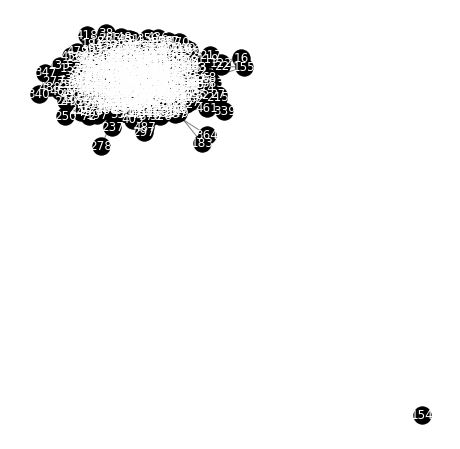

In [8]:
#N = 500
#av_degree = 2
#p = av_degree/(N-1)
GER = nx.gnp_random_graph(N, p, seed=None, directed=False)

N = len(GER)
M = GER.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(GER);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(GER, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(GER, pos, alpha=0.500);
nx.draw_networkx_labels(GER, pos, font_color="white");
plt.show();

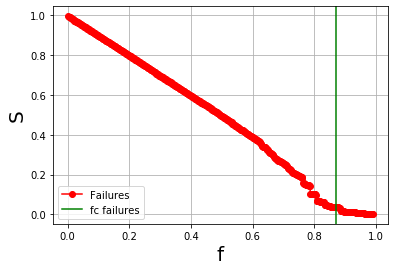

In [9]:
fc = fcritical(GER)

Sf, vnf = failures(GER)

plt.figure()
plt.plot(vnf,Sf,'-or', label='Failures')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

**Barabási-Albert scale free networks**

Number of nodes: 500
Number of edges: 1984
Average degre: 7.936


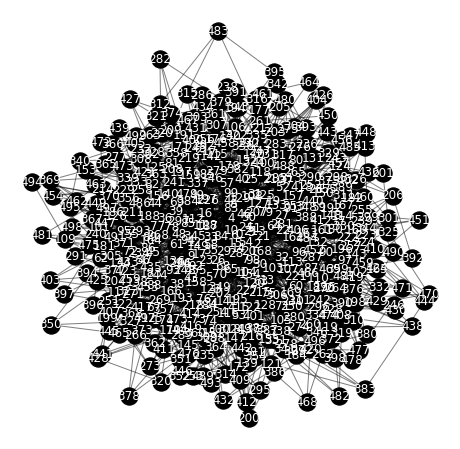

In [10]:
## Criando o graph:
GBA = nx.barabasi_albert_graph(N, m)
N = len(GBA)
M = GBA.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(GBA);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(GBA, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(GBA, pos, alpha=0.500);
nx.draw_networkx_labels(GBA, pos, font_color="white");
plt.show();

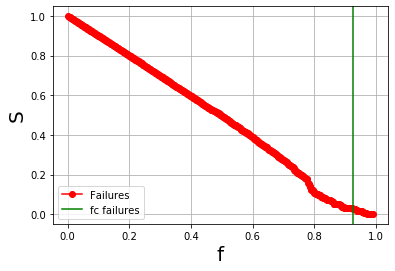

In [11]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(GBA)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = failures(GBA)

plt.figure()
plt.plot(vnf,Sf,'-or', label='Failures')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

**Small-world networks for:**

> p=0.001 

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


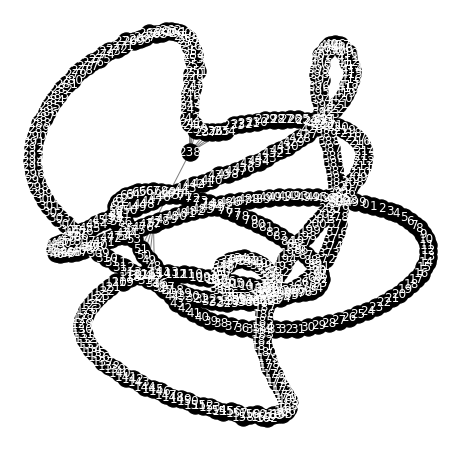

In [12]:
## Criando o graph:
p = 0.001 #probability of rewiring
G001 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G001)
M = G001.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G001);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G001, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G001, pos, alpha=0.500);
nx.draw_networkx_labels(G001, pos, font_color="white");
plt.show();

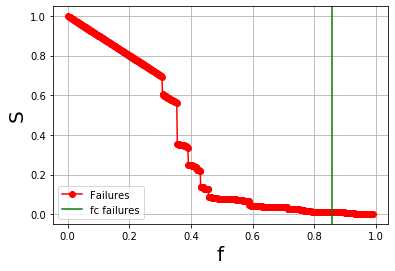

In [13]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G001)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = failures(G001)

plt.figure()
plt.plot(vnf,Sf,'-or', label='Failures')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

> p=0.01

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


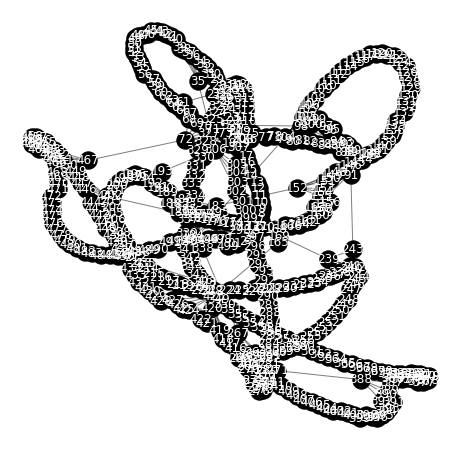

In [14]:
## Criando o graph:
p = 0.01 #probability of rewiring
G01 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G01)
M = G01.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G01);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G01, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G01, pos, alpha=0.500);
nx.draw_networkx_labels(G01, pos, font_color="white");
plt.show();

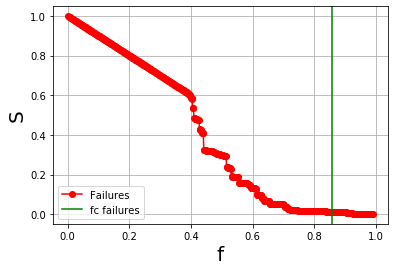

In [15]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G01)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = failures(G01)

plt.figure()
plt.plot(vnf,Sf,'-or', label='Failures')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

> p=0.1.

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


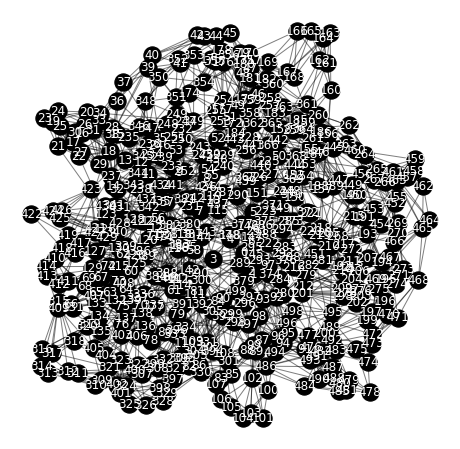

In [16]:
## Criando o graph:
p = 0.1 #probability of rewiring
G1 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G1)
M = G1.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G1);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G1, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G1, pos, alpha=0.500);
nx.draw_networkx_labels(G1, pos, font_color="white");
plt.show();

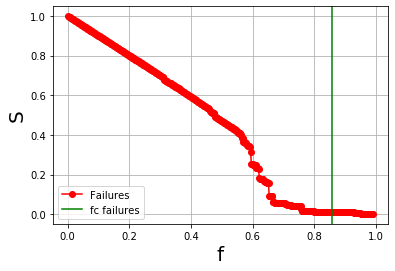

In [17]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G1)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = failures(G1)

plt.figure()
plt.plot(vnf,Sf,'-or', label='Failures')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

Simulate **attacks** in the following networks, obtaining the size of the largest component versus the fraction of removed nodes:

**Erdös-Rényi networks**

Number of nodes: 500
Number of edges: 12472


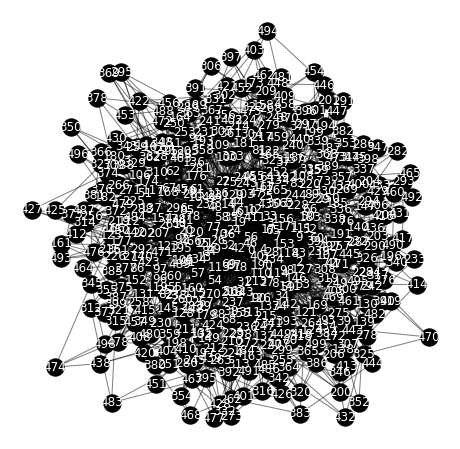

In [18]:
#N = 500
#av_degree = 2
#p = av_degree/(N-1)
GER = nx.gnp_random_graph(N, p, seed=None, directed=False)

N = len(GER)
M = GER.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(GBA);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(GBA, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(GBA, pos, alpha=0.500);
nx.draw_networkx_labels(GBA, pos, font_color="white");
plt.show();

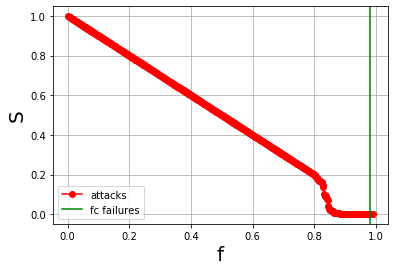

In [19]:
fc = fcritical(GER)

Sf, vnf = attacks(GER)

plt.figure()
plt.plot(vnf,Sf,'-or', label='attacks')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

**Barabási-Albert scale free networks**

Number of nodes: 500
Number of edges: 1984
Average degre: 7.936


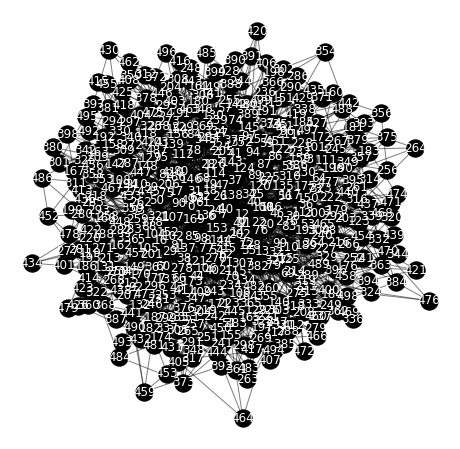

In [20]:
## Criando o graph:
GBA = nx.barabasi_albert_graph(N, m)
N = len(GBA)
M = GBA.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(GBA);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(GBA, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(GBA, pos, alpha=0.500);
nx.draw_networkx_labels(GBA, pos, font_color="white");
plt.show();

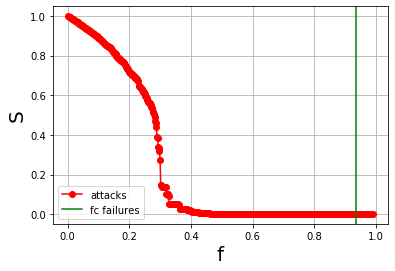

In [21]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(GBA)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = attacks(GBA)

plt.figure()
plt.plot(vnf,Sf,'-or', label='attacks')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

**Small-world networks for:**

> p=0.001 

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


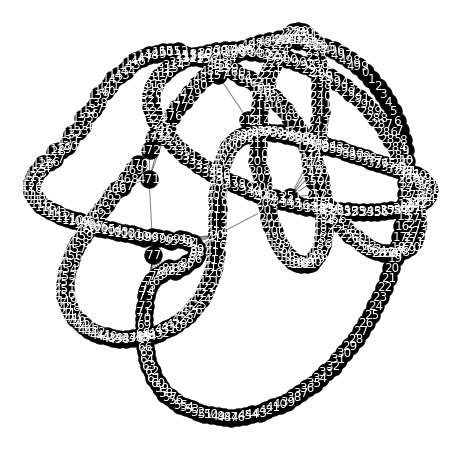

In [22]:
## Criando o graph:
p = 0.001 #probability of rewiring
G001 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G001)
M = G001.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G001);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G001, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G001, pos, alpha=0.500);
nx.draw_networkx_labels(G001, pos, font_color="white");
plt.show();

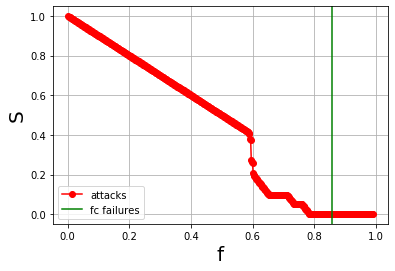

In [23]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G001)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = attacks(G001)

plt.figure()
plt.plot(vnf,Sf,'-or', label='attacks')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

> p=0.01

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


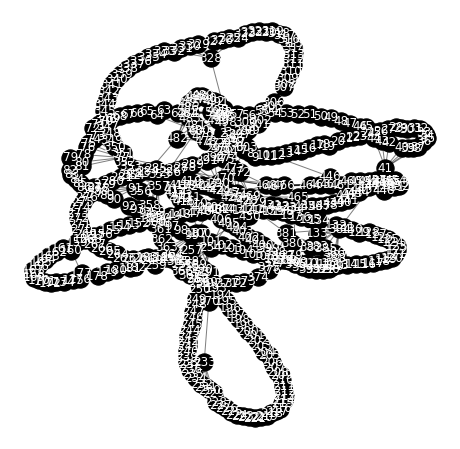

In [24]:
## Criando o graph:
p = 0.01 #probability of rewiring
G01 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G01)
M = G01.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G01);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G01, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G01, pos, alpha=0.500);
nx.draw_networkx_labels(G01, pos, font_color="white");
plt.show();

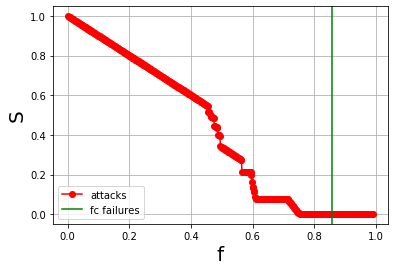

In [25]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G01)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = attacks(G01)

plt.figure()
plt.plot(vnf,Sf,'-or', label='attacks')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

> p=0.1.

Number of nodes: 500
Number of edges: 2000
Average degre: 8.0


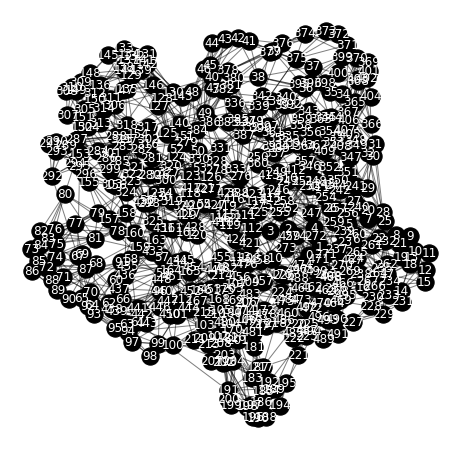

In [26]:
## Criando o graph:
p = 0.1 #probability of rewiring
G1 = nx.watts_strogatz_graph(N, kappa, p, seed=None)
N = len(G1)
M = G1.number_of_edges()

# Visuaçizando o numero de nos, arestas e o grau medio:
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

# Plotando o grafo:
pos = nx.fruchterman_reingold_layout(G1);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G1, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G1, pos, alpha=0.500);
nx.draw_networkx_labels(G1, pos, font_color="white");
plt.show();

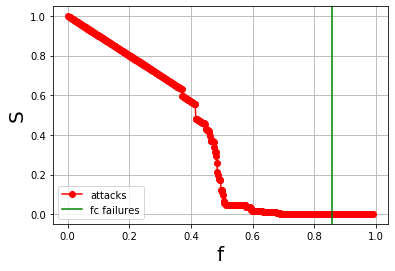

In [27]:
#definindo A probabilidade crítica de reduzir o 
#tamanho do maior componente para zero 
fc = fcritical(G1)
# armazena o tamanho do maior componente,Sf, 
#e vnf é a fração de nós removidos
Sf, vnf = attacks(G1)

plt.figure()
plt.plot(vnf,Sf,'-or', label='attacks')
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.axvline(x=fc, color = 'g', label='fc failures')
plt.legend()
plt.grid(True)
plt.show(); 

***Which network is the most robust against failures?***

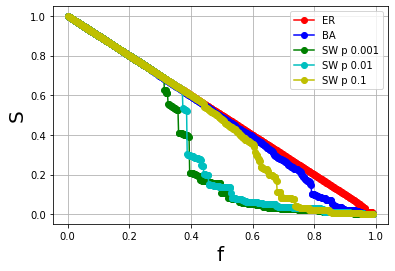

In [28]:
#Small-world networks
Sw001, vnw001 = failures(G001) #p0.1
Sw01, vnw01 = failures(G01) #p0.1
Sw1, vnw1 = failures(G1) #p0.1

#Barabási-Albert scale free networks
SBA, vnBA = failures(GBA)

#Erdös-Rényi networks
SER, vnER = failures(GER)

plt.figure()
plt.plot(vnER,SER,'-or', label='ER')
plt.plot(vnBA,SBA,'-ob', label='BA')
plt.plot(vnw001,Sw001,'-og', label='SW p 0.001')
plt.plot(vnw01,Sw01,'-oc', label='SW p 0.01')
plt.plot(vnw1,Sw1,'-oy', label='SW p 0.1')
plt.legend()
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.grid(True)
plt.show(); 

***Which network is the most robust against attacks?***

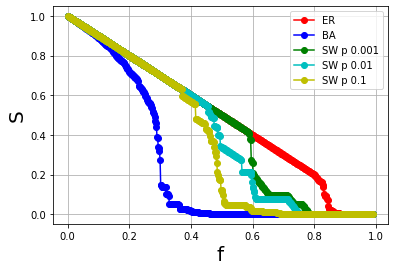

In [29]:
#Small-world networks
Sw001, vnw001 = attacks(G001) #p0.1
Sw01, vnw01 = attacks(G01) #p0.1
Sw1, vnw1 = attacks(G1) #p0.1

#Barabási-Albert scale free networks
SBA, vnBA = attacks(GBA)

#Erdös-Rényi networks
SER, vnER = attacks(GER)

plt.figure()
plt.plot(vnER,SER,'-or', label='ER')
plt.plot(vnBA,SBA,'-ob', label='BA')
plt.plot(vnw001,Sw001,'-og', label='SW p 0.001')
plt.plot(vnw01,Sw01,'-oc', label='SW p 0.01')
plt.plot(vnw1,Sw1,'-oy', label='SW p 0.1')
plt.legend()
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.grid(True)
plt.show(); 

***Compare the protein networks in terms of failures and attacks.***

In [37]:
# Human protein network	
Human = nx.Graph()
Human = nx.read_edgelist("datas/maayan-vidal/out.maayan-vidal", nodetype=int, data=('weight',float),comments='%') # Read the network
Human.remove_edges_from(nx.selfloop_edges(Human))
N = len(Human)
M = Human.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

fc1 = fcritical(Human)

Sf1, vnf1 = failures(Human)
Sa1, vna1 = attacks(Human)

Number of nodes: 3133
Number of edges: 6149


In [39]:
# C.elegans protein network 2007
prtn = nx.Graph()
prtn = nx.read_edgelist("datas/wi2007.txt", nodetype=str) # Read the network
prtn.remove_edges_from(nx.selfloop_edges(prtn))
N = len(prtn)
M = prtn.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

fc2 = fcritical(prtn)

Sf2, vnf2 = failures(prtn)
Sa2, vna2 = attacks(prtn)


Number of nodes: 1496
Number of edges: 1714


In [40]:
# Mosquito interaction network (A. aegypti)
Mosqt = nx.Graph()
df = pd.read_csv('datas/mosquito.csv', header = None, sep = ';')
Mosqt = nx.from_pandas_edgelist(df, 0, 1)
Mosqt = Mosqt.to_undirected()
Mosqt.remove_edges_from(nx.selfloop_edges(Mosqt))
N = len(Mosqt)
M = Mosqt.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

fc3 = fcritical(Mosqt)

Sf3, vnf3 = failures(Mosqt)
Sa3, vna3 = attacks(Mosqt)


Number of nodes: 6263
Number of edges: 64133


**Which species is the most robust?**

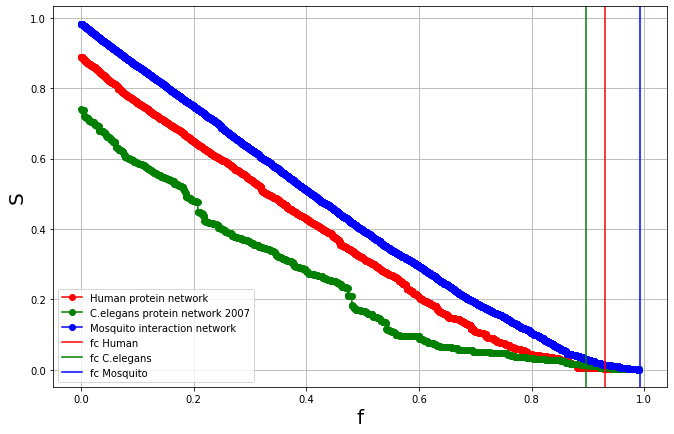

In [41]:
#Analisando as falhas das redes
plt.figure()
plt.plot(vnf1,Sf1,'-or', label='Human protein network')
plt.plot(vnf2,Sf2,'-og', label='C.elegans protein network 2007')
plt.plot(vnf3,Sf3,'-ob', label='Mosquito interaction network')
plt.axvline(x=fc1, color = 'r', label='fc Human')
plt.axvline(x=fc2, color = 'g', label='fc C.elegans')
plt.axvline(x=fc3, color = 'b', label='fc Mosquito')
plt.legend()
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.grid(True)
plt.show(); 

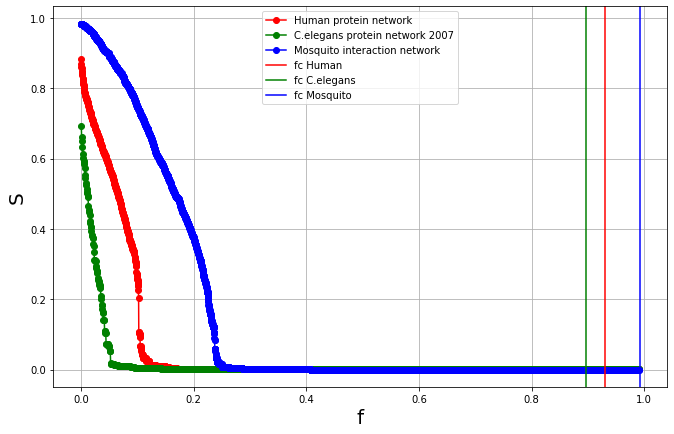

In [42]:
#Analisando os ataques das redes
plt.figure()
plt.plot(vna1,Sa1,'-or', label='Human protein network')
plt.plot(vna2,Sa2,'-og', label='C.elegans protein network 2007')
plt.plot(vna3,Sa3,'-ob', label='Mosquito interaction network')
plt.axvline(x=fc1, color = 'r', label='fc Human')
plt.axvline(x=fc2, color = 'g', label='fc C.elegans')
plt.axvline(x=fc3, color = 'b', label='fc Mosquito')
plt.legend()
plt.xlabel("f", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.grid(True)
plt.show();

Consider the networks with community structure you generated in the 
previous project. Verify how	community organization influences the 
resilience of networks. That is, using the model by Santo Fortunato, 
generate networks with mu = 0.1, 0.3 and 0.5. For these networks 
construct the graph	of the size of the largest component versus the 
fraction of removed	nodes.

*Simulate attacks and failures the LFR_benchmark networks*

In [ ]:
# Primeiro definimios os parametros 
N = 400
tau1 = 3
tau2 = 1.5
k = 16
minc = 32
maxc = 50

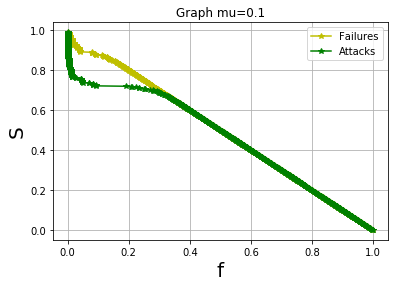

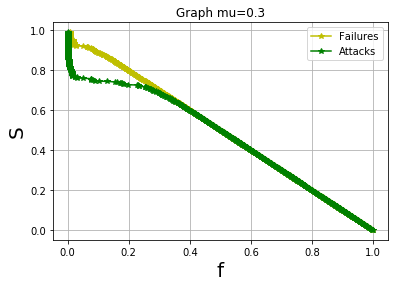

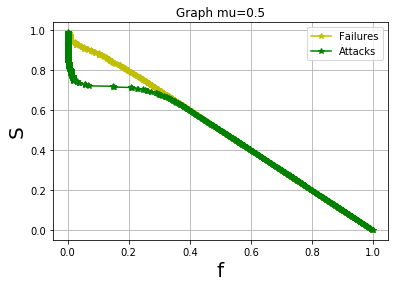

In [19]:
# Partimos pra simulação do modelo Santo Fortunato
for mu in [0.1,0.3,0.5]:
    # Construindo o grafo 
    G = nx.algorithms.community.LFR_benchmark_graph(n = N, tau1 = tau1,
        tau2 = tau2, mu = mu, min_degree = k,
        max_degree = k, min_community=minc,
        max_community = maxc, seed = 10)
    

    # Atacando e aplicando as falhas:
    fail, Sf = failures(G)
    attack, Sa = attacks(G)

    # Por fim plotamos  o mdoleo 
    plt.figure()
    plt.plot(fail,Sf,'-*y', label='Failures')
    plt.plot(attack,Sa,'-*g', label='Attacks')
    plt.xlabel("f", fontsize=20)
    plt.ylabel("S", fontsize=20)
    plt.title('Graph mu='+str(mu))
    plt.legend()
    plt.grid(True)
    plt.show();

# **Questão 2- Epidemic spreading**

Compare	the	epidemic spreading in networks by simulating the reactive 
case in	Erdös-Rényi	networks, Barabási-Albert scale-free networks, and 
small-world	networks for p=0.001, p=0.01 and p=0.1.	N =	500	e <k>=	8. 
Construct the curves of	the	fraction of	infected nodes (SIS	model) versus 
lambda = beta/mu, where	mu = 1

In [27]:
#biblieotecas para  a resposta da questão:

def find(v, i): # function to find the positions of an element in a vector
        l = []
        pos = 0
        for x in v:
            if(x == i):
                l.append(pos)
            pos = pos + 1
        return l

def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes():
        M = M + G.degree(i)**m
    M = M/N
    return M  

def plot_SIS(G, name):
    lbda, rho  = SIS(G)
    plt.figure()
    plt.plot(lbda, rho, 'ro--', label='Simulation')
    plt.xlabel("lambda", fontsize=15)
    plt.ylabel("Fraction of infected nodes", fontsize=15)
    lambda_c = momment_of_degree_distribution(G,1)/momment_of_degree_distribution(G,2)
    plt.axvline(lambda_c, color = 'b', label='Theoretical lambda_c')
    plt.legend()
    plt.title(name, fontsize=30)
    plt.grid(True)
    plt.show(True) 

#Funcao SIS
def SIS(G, mu=1, Tmax = 20):    
    vlbda = list()
    rhoI = list() # vector that stores the fraction of infected nodes according to the parameter lambda
    for lbd in np.arange(0,1, 0.05):
        beta = lbd*mu
        #Reactive process: SIS dynamics
        av_rho = np.zeros(Tmax)
        for seed_node in G.nodes():
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            infected = list() # Stores the number of infected nodes at each time step
            vrho = list()
            # Reactive model
            for t in np.arange(0, Tmax): # Simulate until a maximum number of steps Tmax
                infected = find(vector_states,1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            vector_states[j] = 1
                for k in infected: # try to recover the infected nodes
                    if np.random.rand() < mu:
                        vector_states[k] = 0
                ninfected = len(find(vector_states,1))
                vrho.append(ninfected/N)
            for x in np.arange(0, len(vrho)):
                av_rho[x] = av_rho[x] + vrho[x]
        av_rho = av_rho/len(G.nodes())
        rhoI.append(np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
        vlbda.append(lbd)
    return vlbda, rhoI

def plot_SIR(G, name):
    lbda, rho  = SIR(G)
    plt.figure()
    plt.plot(lbda, rho, 'ro--', label='Simulation')
    plt.xlabel("lambda", fontsize=15)
    plt.ylabel("Fraction of infected nodes", fontsize=15)
    lambda_c = momment_of_degree_distribution(G,1)/momment_of_degree_distribution(G,2)
    plt.axvline(lambda_c, color = 'b', label='Theoretical lambda_c')
    plt.legend()
    plt.title(name, fontsize=30)
    plt.grid(True)
    plt.show(True) 

#Funcao SIR
def SIR(G, mu=1, Tmax = 20):   
    N =  len(G.nodes())+1
    vlbda = list()
    rhoI = list() # vector that stores the fraction of infected nodes according to the parameter lambda
    for lbd in np.arange(0,1, 0.05):
        beta = lbd*mu
        #Reactive process: SIR dynamics
        av_rho = np.zeros(Tmax)
        for seed_node in G.nodes():
            vector_states = np.zeros(N) # vector that stores the states of the vertices
            vector_states[seed_node] = 1 # vector that stores the states
            ninfected = 1
            infected = list() # Stores the number of infected nodes at each time step
            vrho = list()
            # Reactive model
            for t in np.arange(0, Tmax): # Simulate until a maximum number of steps Tmax
                infected = find(vector_states,1) # list of infected nodes
                for i in infected: # try to infect the neighbors
                    neigs = G.neighbors(i)
                    for j in neigs:
                        if np.random.rand() < beta:
                            if(vector_states[j] != 2): # verify if the node is not recovered
                                vector_states[j] = 1
                for k in infected: # try to recover the infected nodes
                    if np.random.rand() < mu:
                        vector_states[k] = 2
                ninfected = len(find(vector_states,1))
                vrho.append(ninfected/N)
            for x in np.arange(0, len(vrho)):
                av_rho[x] = av_rho[x] + vrho[x]
        av_rho = av_rho/len(G.nodes())
        rhoI.append(np.mean(av_rho[np.arange(int(0.8*Tmax), Tmax)]))
        vlbda.append(lbd)
    return vlbda, rhoI

In [15]:
# 1. Setting networks parameters
N = 500              # number of nodes
av_degree = 8        # average degree
p = av_degree/(N-1)  # probability
m = int(av_degree/2) # probability for edge creation

# 2. Building Networks
erdos = nx.gnp_random_graph(N, p, seed=None, directed=False)
bara = nx.barabasi_albert_graph(N, m)
sw001 = nx.watts_strogatz_graph(N, m, 0.001, seed=None)
sw01 = nx.watts_strogatz_graph(N, m, 0.01, seed=None)
sw1 = nx.watts_strogatz_graph(N, m, 0.1, seed=None)
sw1 = nx.watts_strogatz_graph(N, m, 0.1, seed=None)

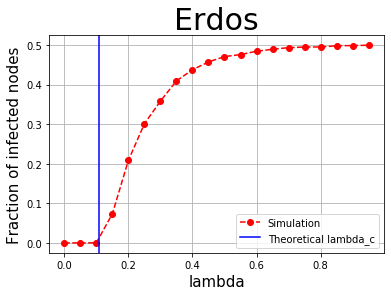

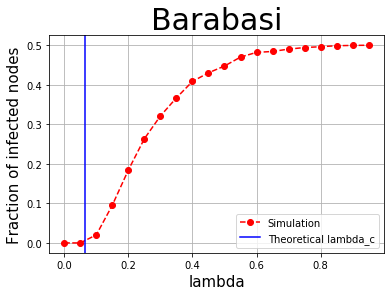

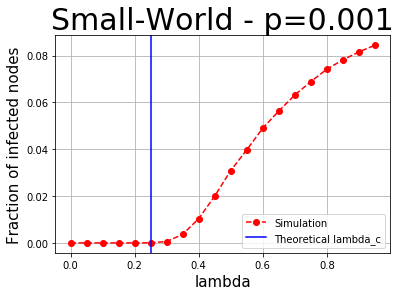

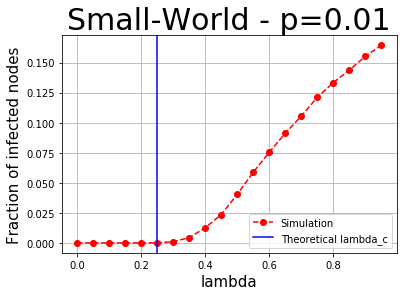

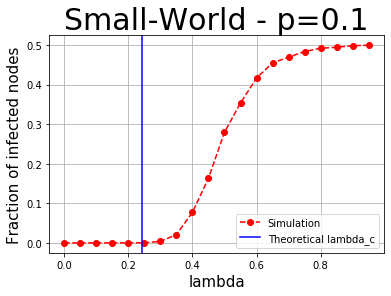

In [16]:
plot_SIS(erdos,"Erdos")
plot_SIS(bara, "Barabasi")
plot_SIS(sw001, "Small-World - p=0.001")
plot_SIS(sw01, "Small-World - p=0.01")
plot_SIS(sw1, "Small-World - p=0.1")

***Consider the same  analysis for the SIR epidemic model***

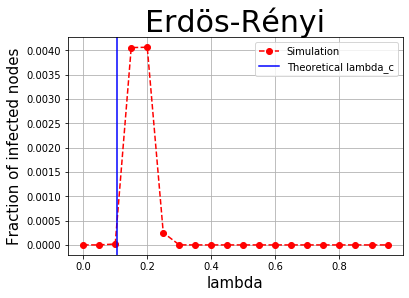

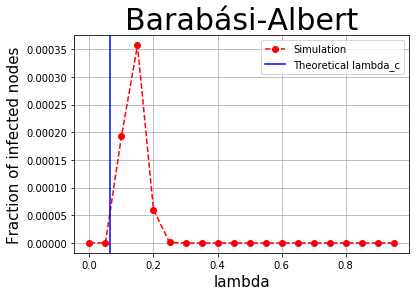

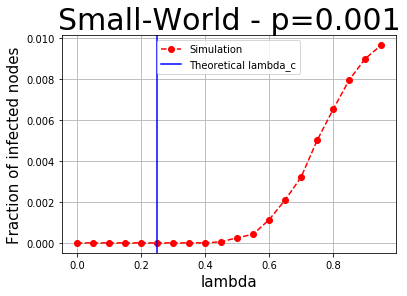

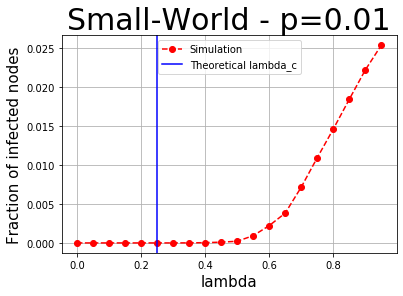

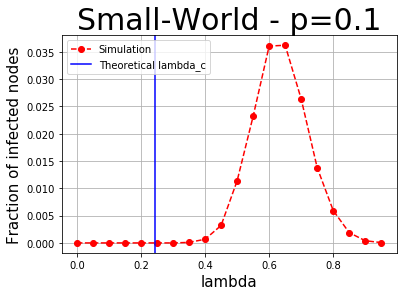

In [28]:
plot_SIR(erdos, "Erdös-Rényi")
plot_SIR(bara, "Barabási-Albert")
plot_SIR(sw001, "Small-World - p=0.001")
plot_SIR(sw01, "Small-World - p=0.01")
plot_SIR(sw1, "Small-World - p=0.1")

# **Questão 3-Influential spreaders**

Construct the plot of the fraction of removed nodes (in the SIR dynamics)
versus a centrality measure (degree, betweenness centrality, closeness
centrality, eigenvector centrality, accessibility, k-core and
communicability centrality). Verify which of these measures most
influence the fraction of removed nodes.

In [22]:
def plot_rmnodes_measure(rmnodes,measure,plot_title):
    plt.figure()
    plt.plot(rmnodes, measure, 'b*--', label='Simulation')
    plt.xlabel("Centrality Measure", fontsize=15)
    plt.ylabel("Fraction of infected nodes", fontsize=15)
    plt.legend()
    plt.title(plot_title, fontsize=30)
    plt.grid(True)
    plt.show(True) 

In [23]:
def acc(G):
    N = len(G.nodes())
    vk = dict(G.degree())
    vk = list(vk.values())
    A = nx.adjacency_matrix(G)
    P = np.zeros((N,N), dtype = 'float')
    for i in np.arange(0, N):
        for j in np.arange(i, N):
            if(vk[i] > 0):
                P[i,j] = A[i,j]/vk[i]

    P2 = expm(P)/np.exp(1)

    vacc = np.zeros(N, dtype = float)
    for i in np.arange(0, N):
        acc = 0
        for j in np.arange(0,N):
            if(P2[i,j] > 0):
                acc = acc + P2[i,j]*log(P2[i,j])
        acc = np.exp(-acc)
        vacc[i] = acc
    return vacc

def comm_cent(G):
    if nx.is_weighted(G):
        tg = nx.Graph()
        for u, v, w in G.edges(data=True):
            if w['weight'] > 0:
                tg.add_edge(u,v)
        G = tg
    A = nx.adjacency_matrix(G)
    C = expm(csc_matrix(A))
    N = len(G)
    com = np.zeros(N)
    for i in range(0, N):
        com[i] = C[i,i]
    return com

In [24]:
def calc(G):

    # Calculating the degree centrality
    vk = dict(G.degree())
    vk = list(vk.values())

    # Calculating the betweenness centrality
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())

    # Calculating the closeness centrality
    CLC = dict(nx.closeness_centrality(G))
    CLC = list(CLC.values())

    # Calculating the eigenvector centrality
    EC = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    EC = list(EC.values())
    
    # Calculating the k-core centrality
    KC = dict(nx.core_number(G))
    KC = list(KC.values())
    
    # Calculating the accessibility
    RW = acc(G)

    CC = comm_cent(G) 
    
    return vk,B,CLC,EC,KC,RW,CC

**a)** Hamsterster friendships

In [53]:
#hams = read_network('datas/hamster.txt', '%', 'txt')
#hams.remove_edges_from(nx.selfloop_edges(hams))
hams = nx.Graph()
hams = nx.read_edgelist('datas/hamster.txt', nodetype=int, comments='%')
hams = hams.to_undirected()
hams.remove_edges_from(nx.selfloop_edges(hams))


vk_hams,B_hams,CLC_hams,EC_hams,KC_hams,RW_hams,CC_hams = calc(hams)
lbda_hams, rho_hams  = SIR(hams)

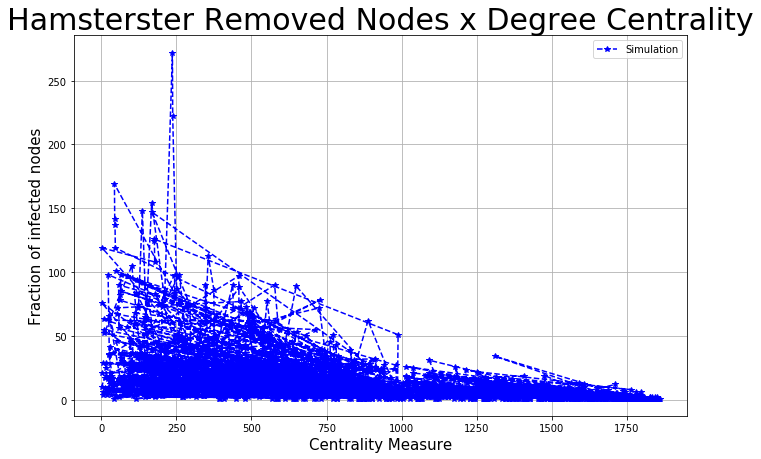

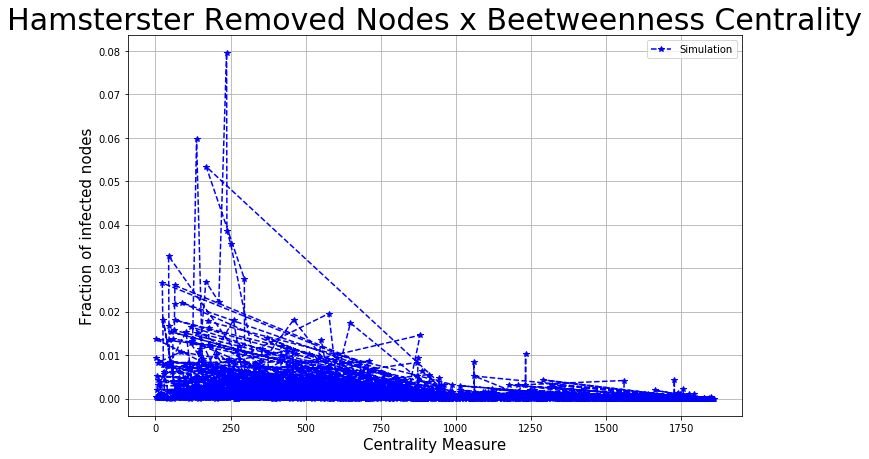

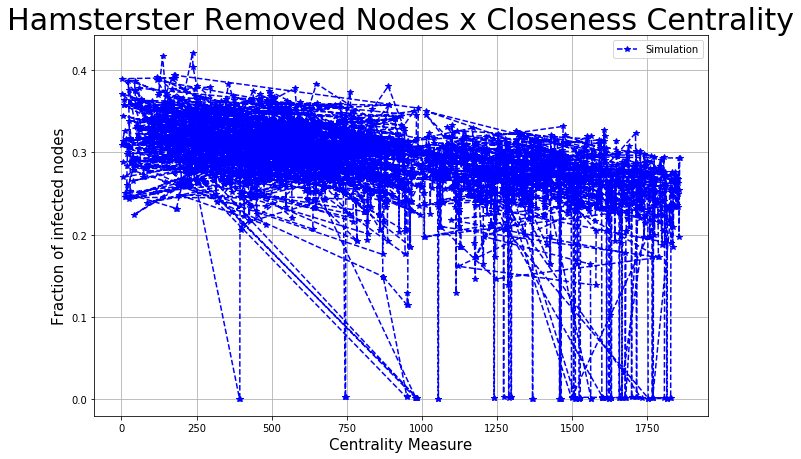

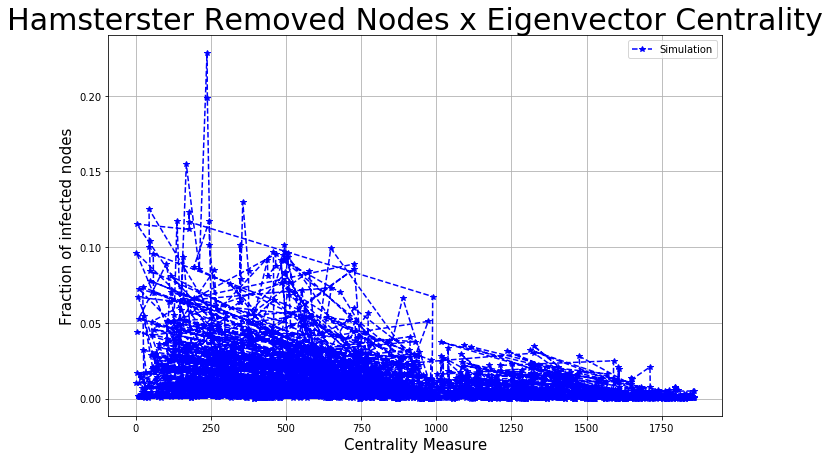

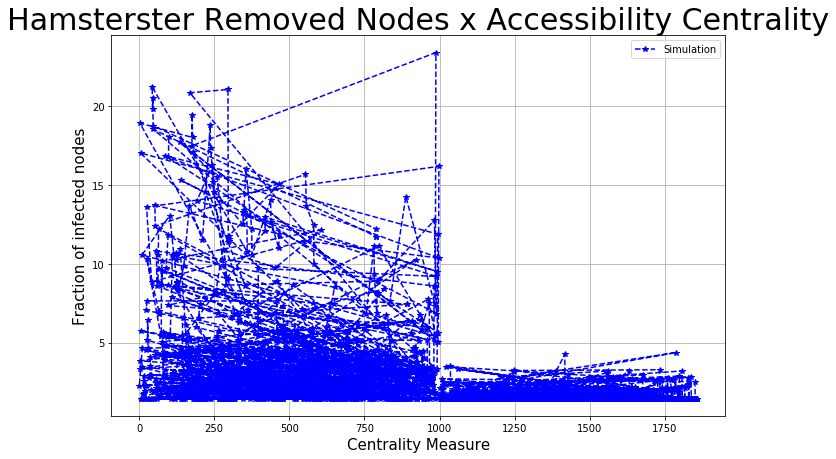

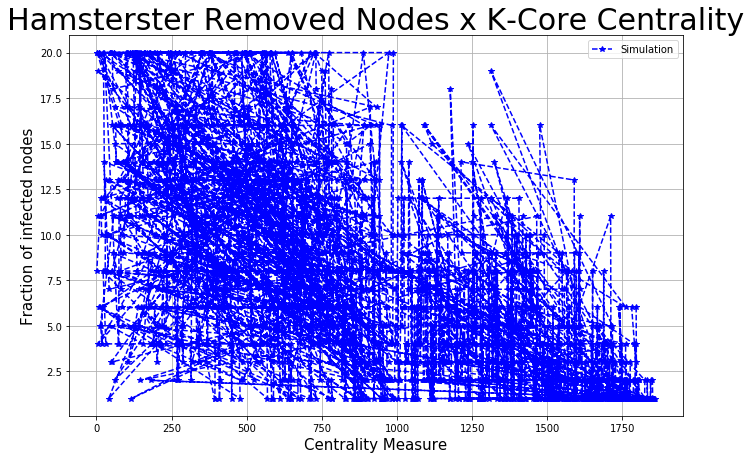

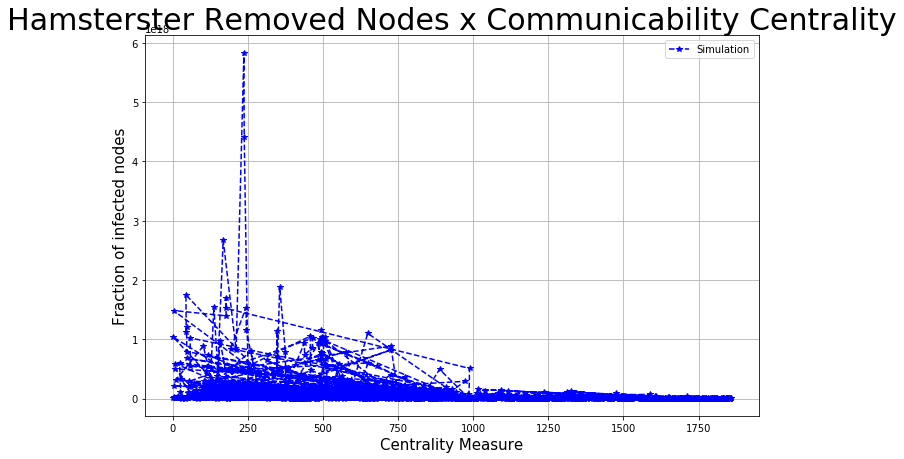

In [54]:
plot_rmnodes_measure(hams,vk_hams,'Hamsterster Removed Nodes x Degree Centrality')
plot_rmnodes_measure(hams,B_hams,'Hamsterster Removed Nodes x Beetweenness Centrality')
plot_rmnodes_measure(hams,CLC_hams,'Hamsterster Removed Nodes x Closeness Centrality')
plot_rmnodes_measure(hams,EC_hams,'Hamsterster Removed Nodes x Eigenvector Centrality')
plot_rmnodes_measure(hams,RW_hams,'Hamsterster Removed Nodes x Accessibility Centrality')
plot_rmnodes_measure(hams,KC_hams,'Hamsterster Removed Nodes x K-Core Centrality')
plot_rmnodes_measure(hams,CC_hams,'Hamsterster Removed Nodes x Communicability Centrality')

**b)** C. elegans neural network

In [40]:
elegans = nx.Graph()
elegans = nx.read_weighted_edgelist("/home/clayton/Downloads/Redes-Complexas-master/Projeto4/datas/celegansneural.mtx", nodetype=int,comments  = "%")
elegans = nx.Graph(elegans)
elegans = elegans.to_undirected()
elegans = nx.convert_node_labels_to_integers(elegans, first_label=0)
elegans.remove_edges_from(nx.selfloop_edges(elegans))

vk_elegans,B_elegans,CLC_elegans,EC_elegans,KC_elegans,RW_elegans,CC_elegans = calc(elegans)
lbda_elegans, rho_elegans  = SIR(elegans)

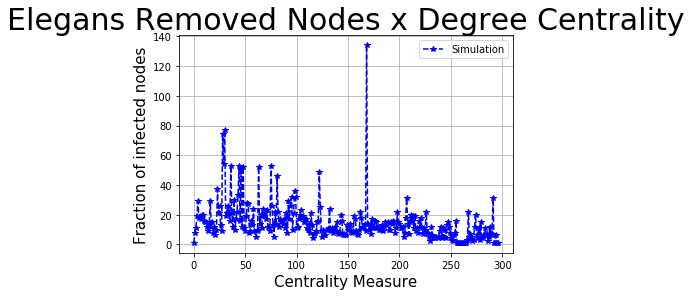

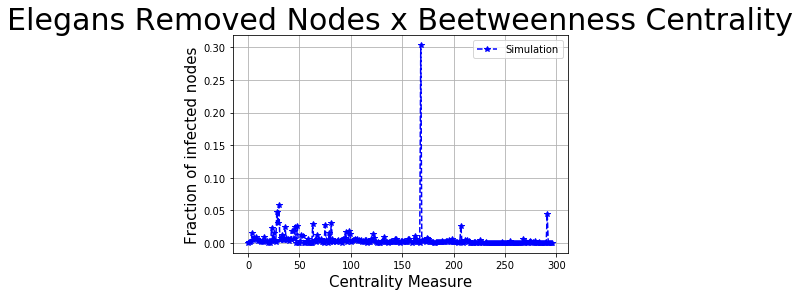

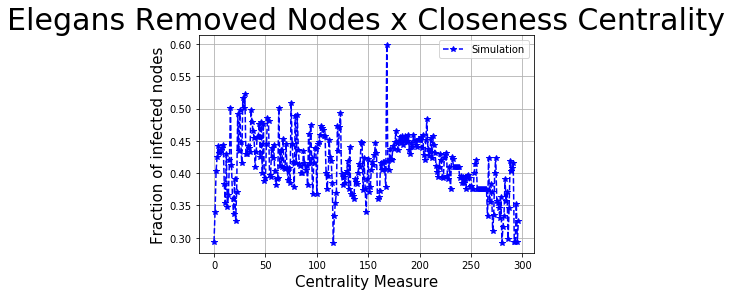

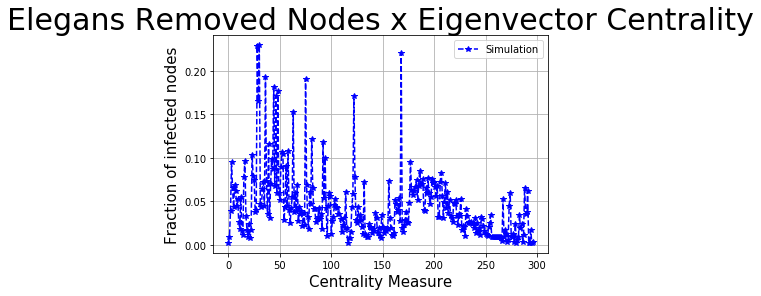

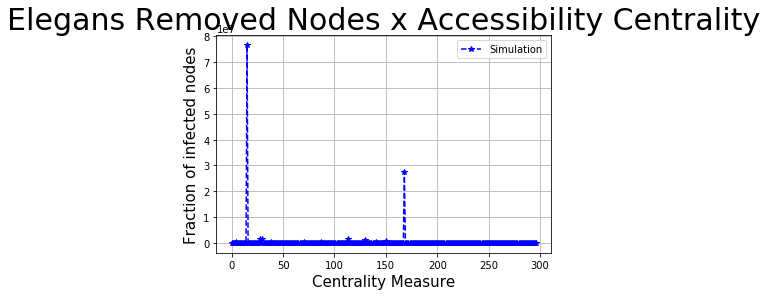

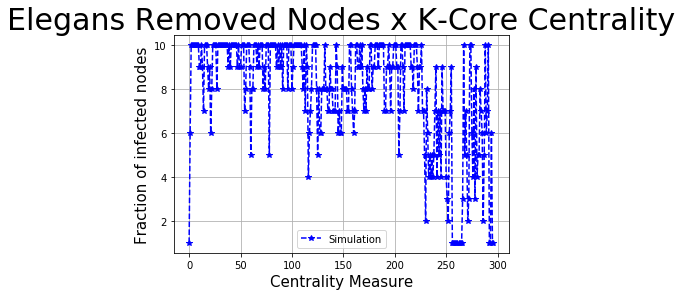

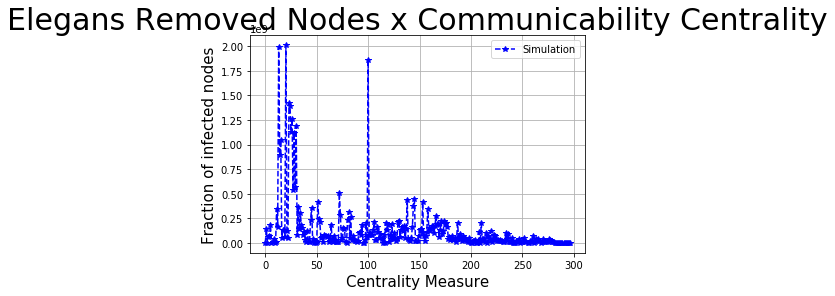

In [41]:
plot_rmnodes_measure(elegans,vk_elegans,'Elegans Removed Nodes x Degree Centrality')
plot_rmnodes_measure(elegans,B_elegans,'Elegans Removed Nodes x Beetweenness Centrality')
plot_rmnodes_measure(elegans,CLC_elegans,'Elegans Removed Nodes x Closeness Centrality')
plot_rmnodes_measure(elegans,EC_elegans,'Elegans Removed Nodes x Eigenvector Centrality')
plot_rmnodes_measure(elegans,RW_elegans,'Elegans Removed Nodes x Accessibility Centrality')
plot_rmnodes_measure(elegans,KC_elegans,'Elegans Removed Nodes x K-Core Centrality')
plot_rmnodes_measure(elegans,CC_elegans,'Elegans Removed Nodes x Communicability Centrality')

**c)** US airport network

In [42]:
airport = nx.Graph()
airport = nx.read_edgelist("/home/clayton/Downloads/Redes-Complexas-master/Projeto4/datas/USairport500.txt", nodetype=int, data=(('weight',int),))
airport = airport.to_undirected()
airport.remove_edges_from(nx.selfloop_edges(airport))

vk_airport,B_airport,CLC_airport,EC_airport,KC_airport,RW_airport,CC_airport = calc(airport)
lbda_airport, rho_airport  = SIR(elegans)

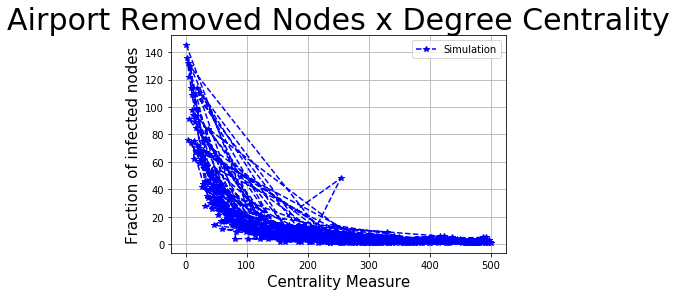

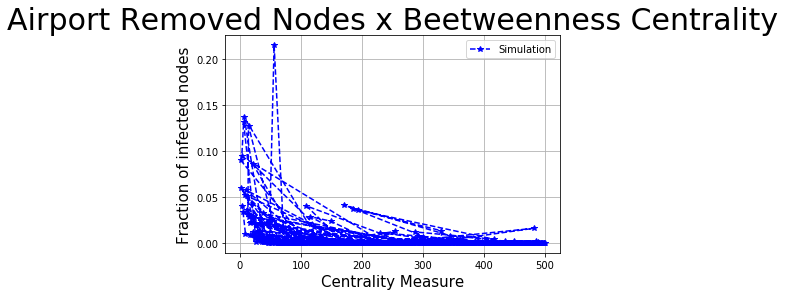

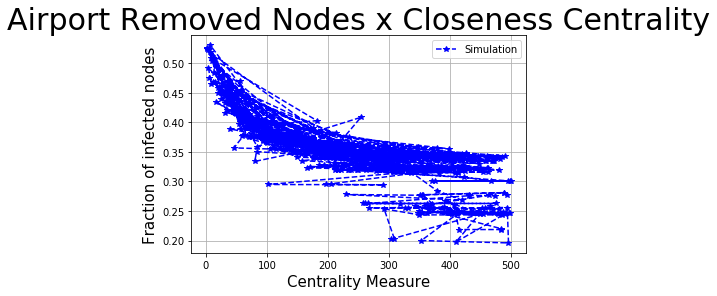

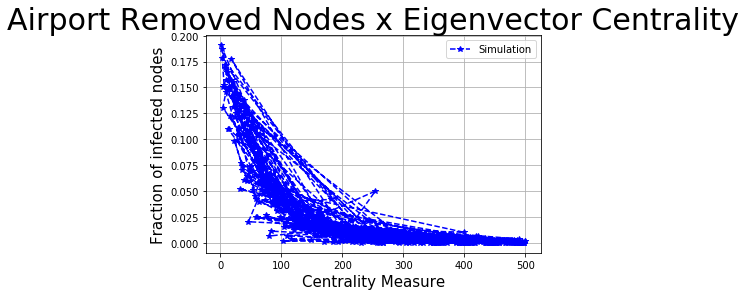

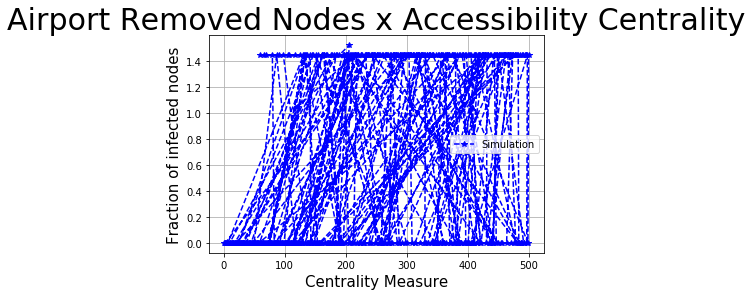

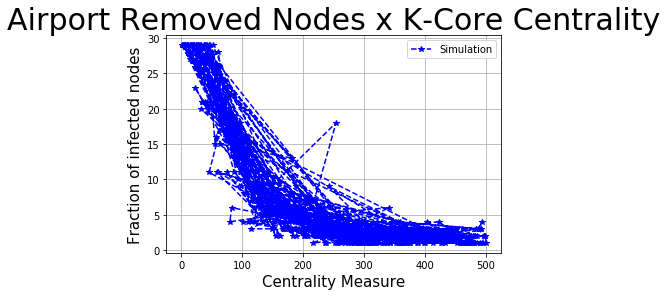

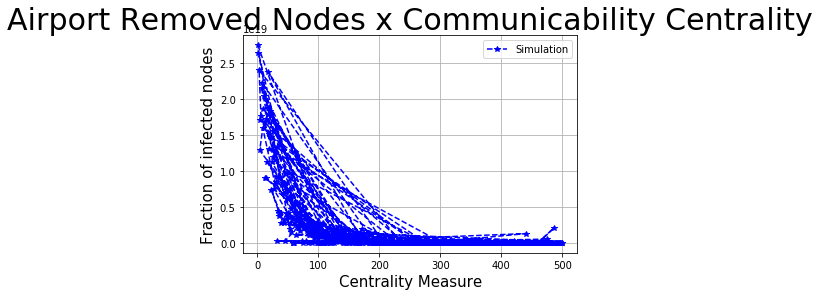

In [43]:
plot_rmnodes_measure(airport,vk_airport,'Airport Removed Nodes x Degree Centrality')
plot_rmnodes_measure(airport,B_airport,'Airport Removed Nodes x Beetweenness Centrality')
plot_rmnodes_measure(airport,CLC_airport,'Airport Removed Nodes x Closeness Centrality')
plot_rmnodes_measure(airport,EC_airport,'Airport Removed Nodes x Eigenvector Centrality')
plot_rmnodes_measure(airport,RW_airport,'Airport Removed Nodes x Accessibility Centrality')
plot_rmnodes_measure(airport,KC_airport,'Airport Removed Nodes x K-Core Centrality')
plot_rmnodes_measure(airport,CC_airport,'Airport Removed Nodes x Communicability Centrality')